In [1]:
# hack to make notebook appear full-width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import numpy as np
import pandas

import matplotlib.pyplot as plt

import mapalgo as MAP

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [39]:
from importlib import reload

reload(MAP)

<module 'mapalgo' from '/Users/dbeach/Desktop/stableyes/src/mapalgo.py'>

In [331]:
autos = pandas.read_csv("../data/automobiles.csv", na_values="?")

print(autos.columns)

Index(['symbolizing', 'normalized_losses', 'make', 'fuel_type', 'aspiration',
       'num_of_doors', 'body_style', 'drive_wheels', 'engine_location',
       'wheel_base', 'length', 'width', 'height', 'curb_weight', 'engine_type',
       'num_of_cylinders', 'engine_size', 'fuel_system', 'bore', 'stroke',
       'compression_ratio', 'horsepower', 'peak_rpm', 'city_mpg',
       'highway_mpg', 'price'],
      dtype='object')


In [332]:
meta_attrs = [
    "make", "fuel_type", "aspiration", "num_of_doors", "body_style",
    "drive_wheels", "engine_location", "num_of_cylinders", "fuel_system"
]
engine_attrs = ["engine_size", "bore", "stroke", "compression_ratio", "horsepower", "peak_rpm"]
body_attrs = ["wheel_base", "length", "width", "height", "curb_weight"]

In [333]:
avail_data = autos[meta_attrs + engine_attrs + body_attrs].dropna()

engine_data = MAP.zscore(avail_data[engine_attrs].as_matrix())
body_data = MAP.zscore(avail_data[body_attrs].as_matrix())

engine_map0 = MAP.create_map_from_data("Engine", engine_data, perplexity=20.0)
body_map0 = MAP.create_map_from_data("Body", body_data, perplexity=20.0)

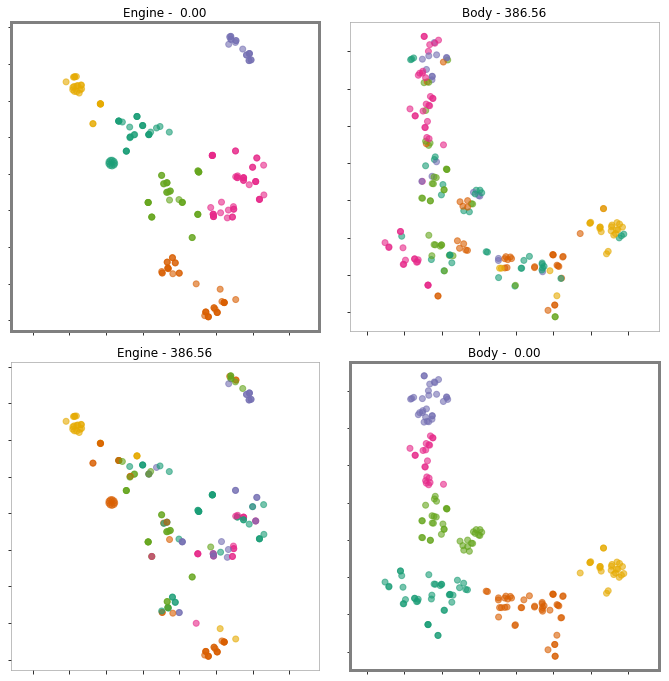

In [105]:
MAP.show_map_matrix([engine_map0, body_map0])

In [106]:
concat_data = MAP.zscore(avail_data[engine_attrs + body_attrs].as_matrix())
concat_data_b = concat_data.copy()
concat_data_b[:,0:6] *= 0.25 * (1/6.)
concat_data_b[:,6:11] *= 0.75 * (1/5.)

concat_data_e = concat_data.copy()
concat_data_e[:,0:6] *= 0.75 * (1/6.)
concat_data_e[:,6:11] *= 0.25 * (1/5.)

In [107]:
concat_map = MAP.create_map_from_data("Concat", concat_data, perplexity=20.0)
engine_map = MAP.create_map_from_data("Engine", engine_data, perplexity=20.0, prior=concat_map)
body_map = MAP.create_map_from_data("Body", body_data, perplexity=20.0, prior=concat_map)
concat_map_e = MAP.create_map_from_data("Concat E", concat_data_e, perplexity=20.0, prior=concat_map)
concat_map_b = MAP.create_map_from_data("Concat B", concat_data_b, perplexity=20.0, prior=concat_map)

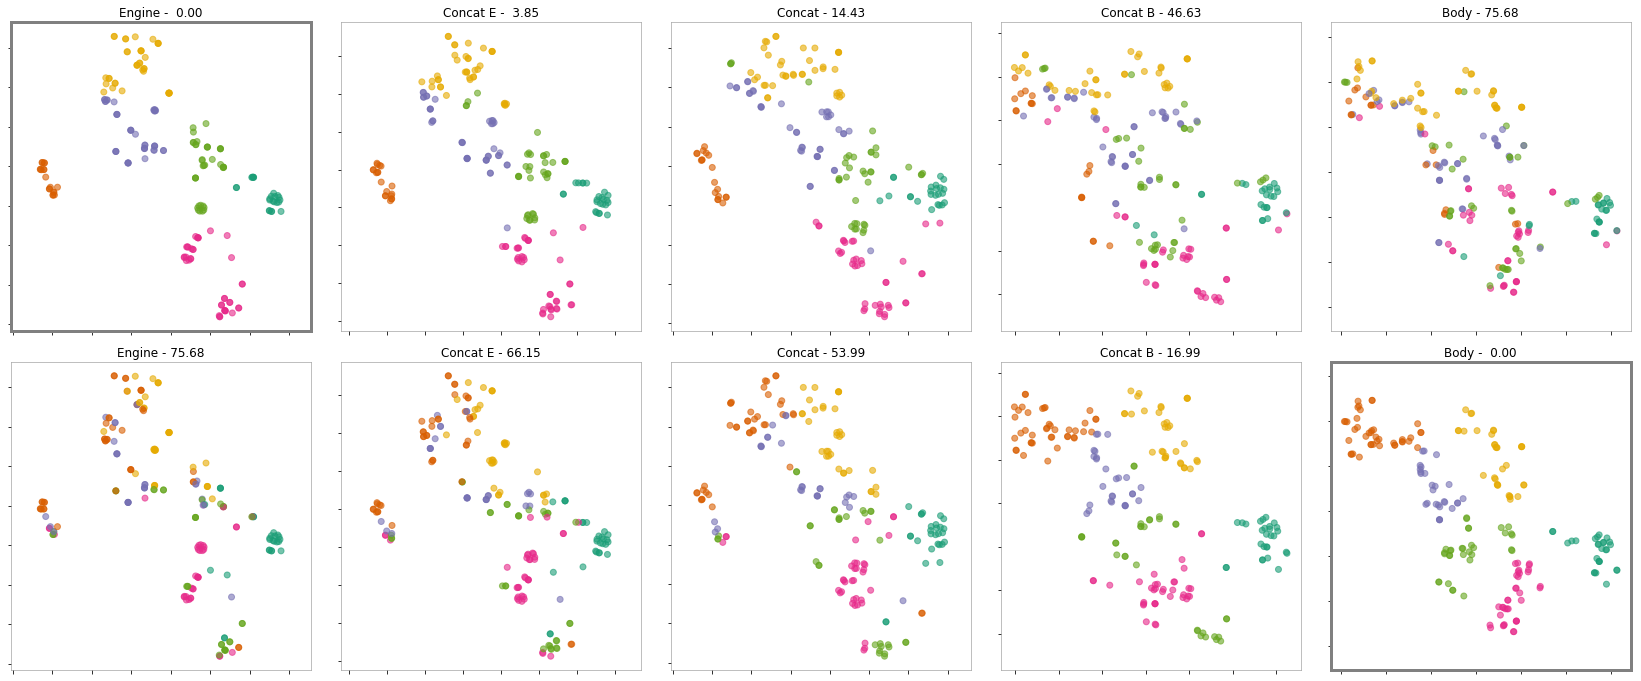

In [108]:
MAP.show_map_matrix([engine_map, concat_map_e, concat_map, concat_map_b, body_map], keys=[engine_map, body_map])

In [113]:
linear_25 = MAP.create_map("Linear 25%", (engine_map.prob*.75 + body_map.prob*.25), prior=concat_map)
linear_50 = MAP.create_map("Linear 50%", (engine_map.prob*.5 + body_map.prob*.5), prior=concat_map)
linear_75 = MAP.create_map("Linear 75%", (engine_map.prob*.25 + body_map.prob*.75), prior=concat_map)

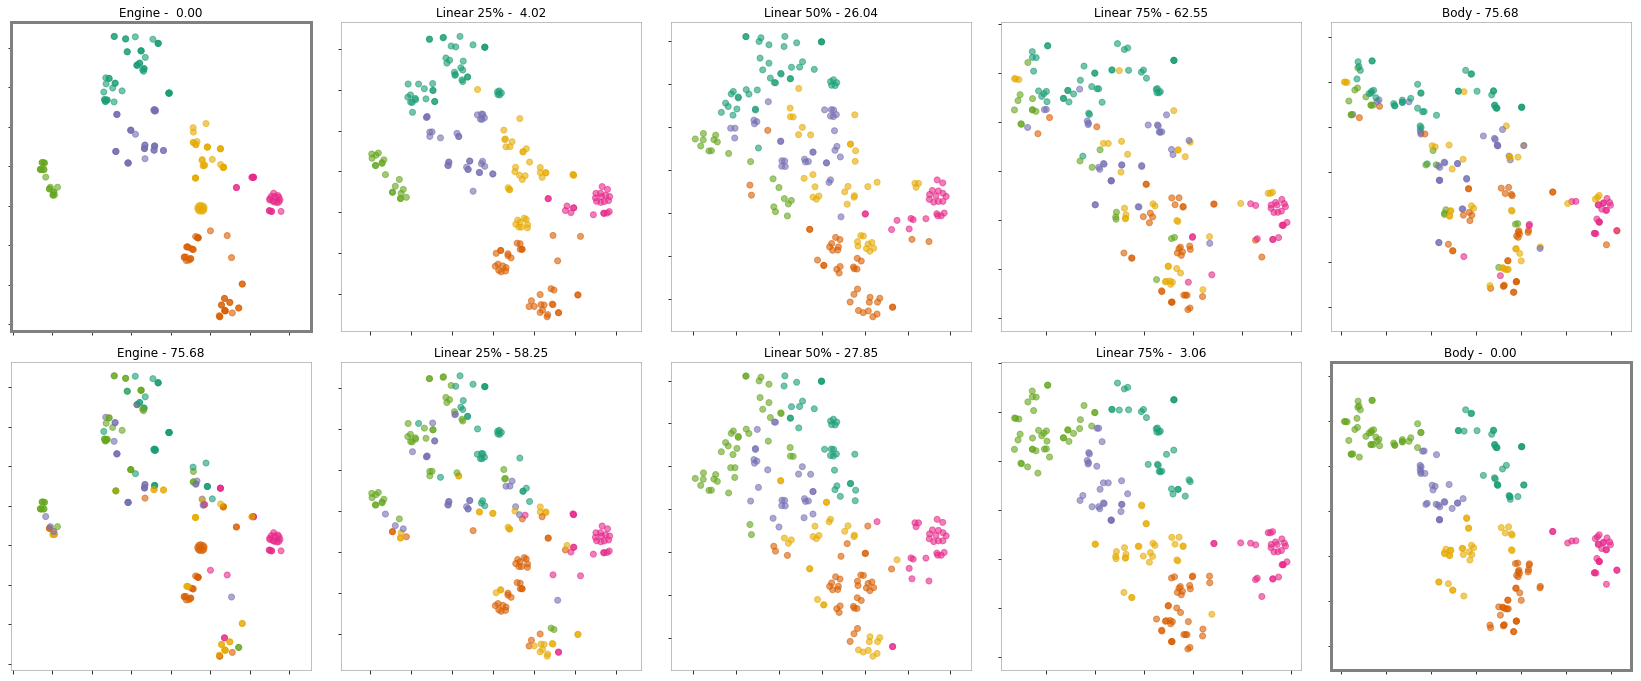

In [114]:
MAP.show_map_matrix([engine_map, linear_25, linear_50, linear_75, body_map], keys=[engine_map, body_map])

In [307]:
COLORS = [
    "#1b9e77",
    "#d95f02",
    "#7570b3",
    "#e7298a",
    "#66a61e",
    "#e6ab02",
]

def color_by(ax, map, meta_attr, legend=True):
    vals = avail_data[meta_attr].unique()
    mapping = dict(zip(vals, range(len(vals))))
    colors = [COLORS[mapping[s] % len(COLORS)] for s in avail_data[meta_attr]]
    ax.scatter(map.y[:,0], map.y[:,1], color=colors, s=20)
    if legend:
        for style, idx in mapping.items():
            ax.scatter([], [], color=COLORS[idx], label=style, s=20)
        ax.legend()
    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_major_formatter(plt.NullFormatter())
    ax.axis('equal')
    ax.axis('equal')
    ax.set_title(f"{map.name} - {meta_attr}")

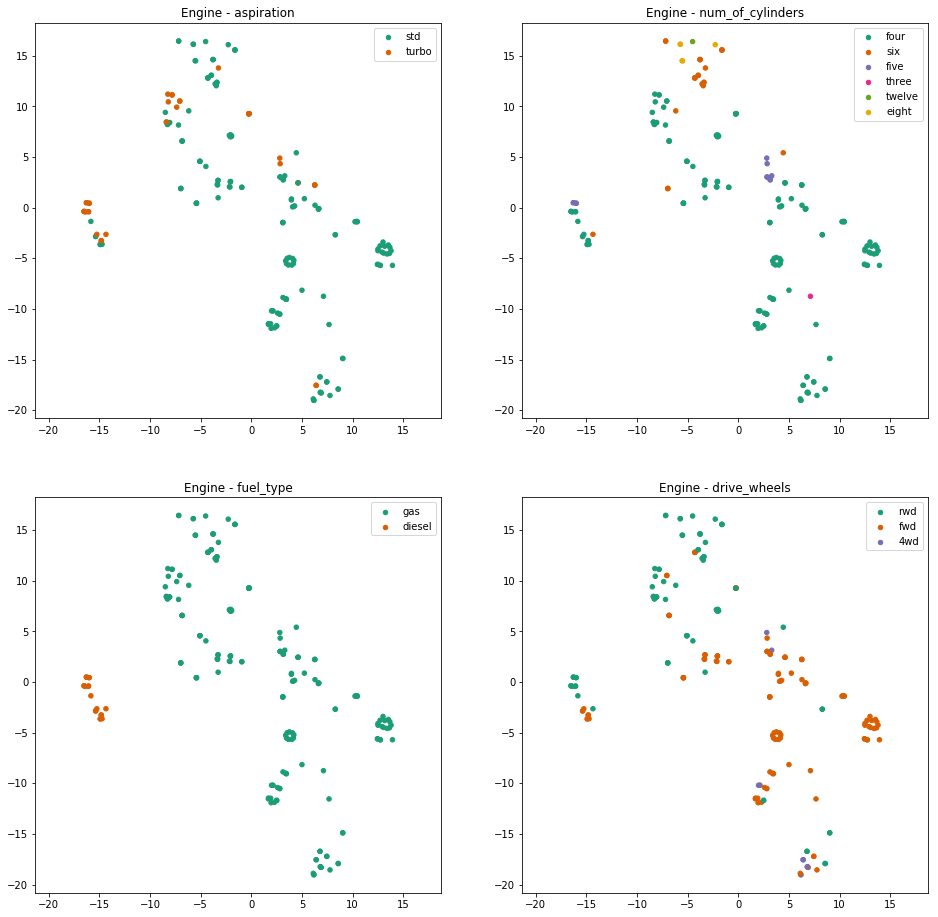

In [140]:
fig, ax = plt.subplots(2, 2, figsize=(16,16))
color_by(ax[0,0], engine_map, "aspiration")
color_by(ax[0,1], engine_map, "num_of_cylinders")
color_by(ax[1,0], engine_map, "fuel_type")
color_by(ax[1,1], engine_map, "drive_wheels")

In [141]:
def blend_compare(meta_attr):
    fig, ax = plt.subplots(2, 5, figsize=(25,10))
    color_by(ax[0,0], engine_map, meta_attr)
    color_by(ax[0,1], concat_map_e, meta_attr, legend=False)
    color_by(ax[0,2], concat_map, meta_attr, legend=False)
    color_by(ax[0,3], concat_map_b, meta_attr, legend=False)
    color_by(ax[0,4], body_map, meta_attr, legend=False)

    color_by(ax[1,0], engine_map, meta_attr)
    color_by(ax[1,1], linear_25, meta_attr, legend=False)
    color_by(ax[1,2], linear_50, meta_attr, legend=False)
    color_by(ax[1,3], linear_75, meta_attr, legend=False)
    color_by(ax[1,4], body_map, meta_attr, legend=False)

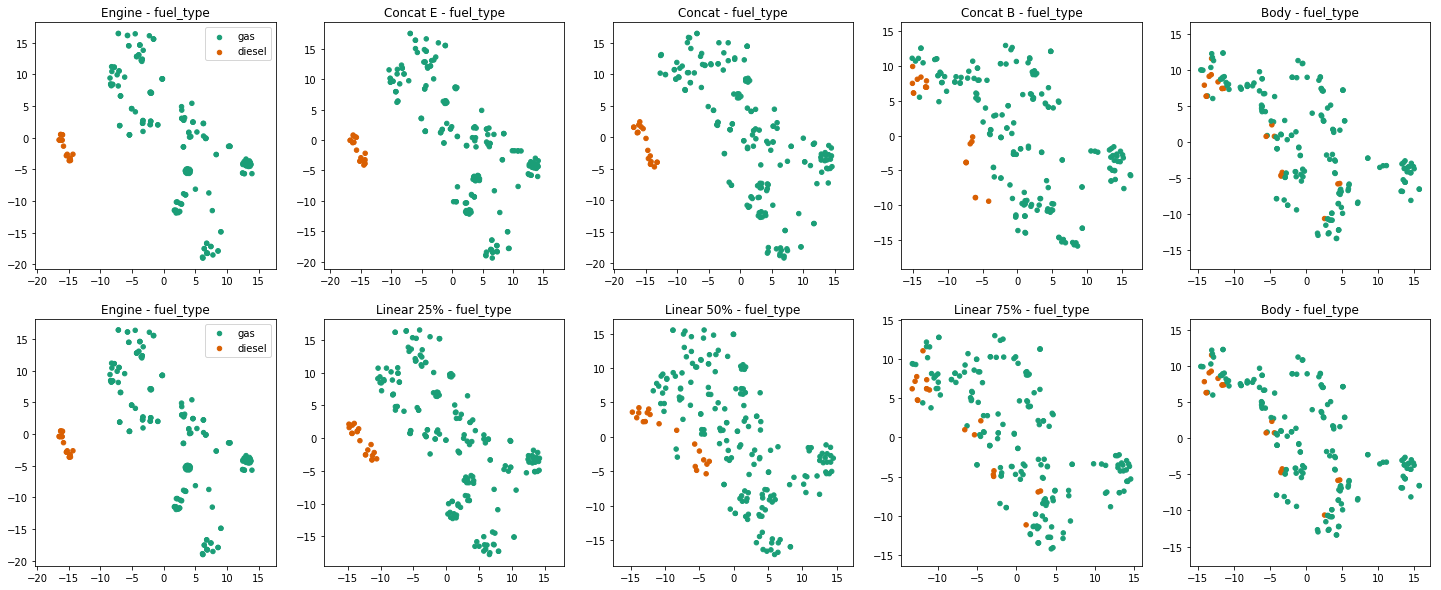

In [142]:
blend_compare("fuel_type")

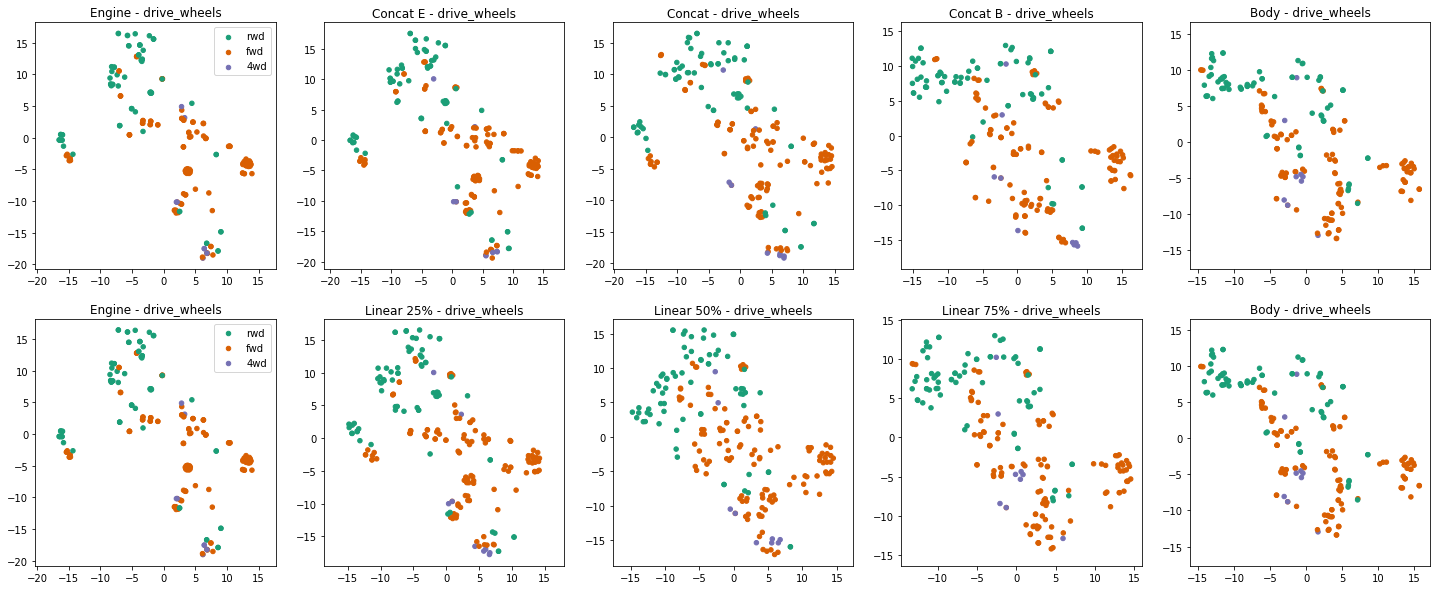

In [143]:
blend_compare("drive_wheels")

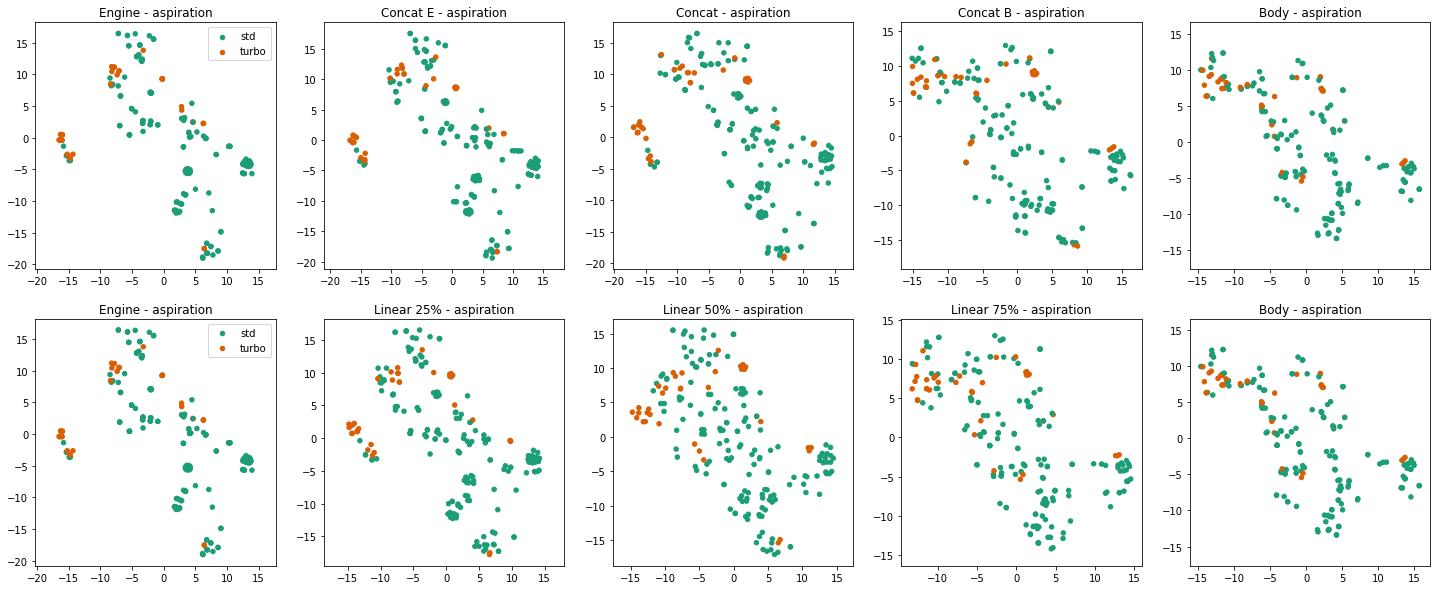

In [144]:
blend_compare("aspiration")

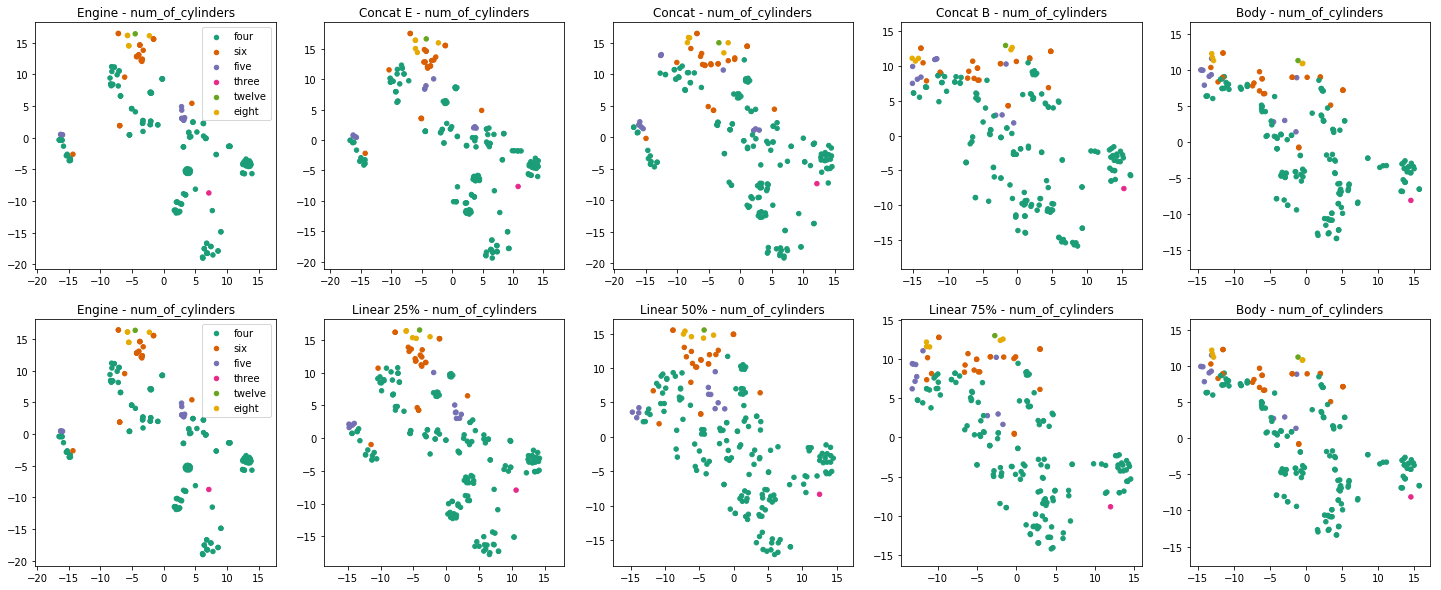

In [145]:
blend_compare("num_of_cylinders")

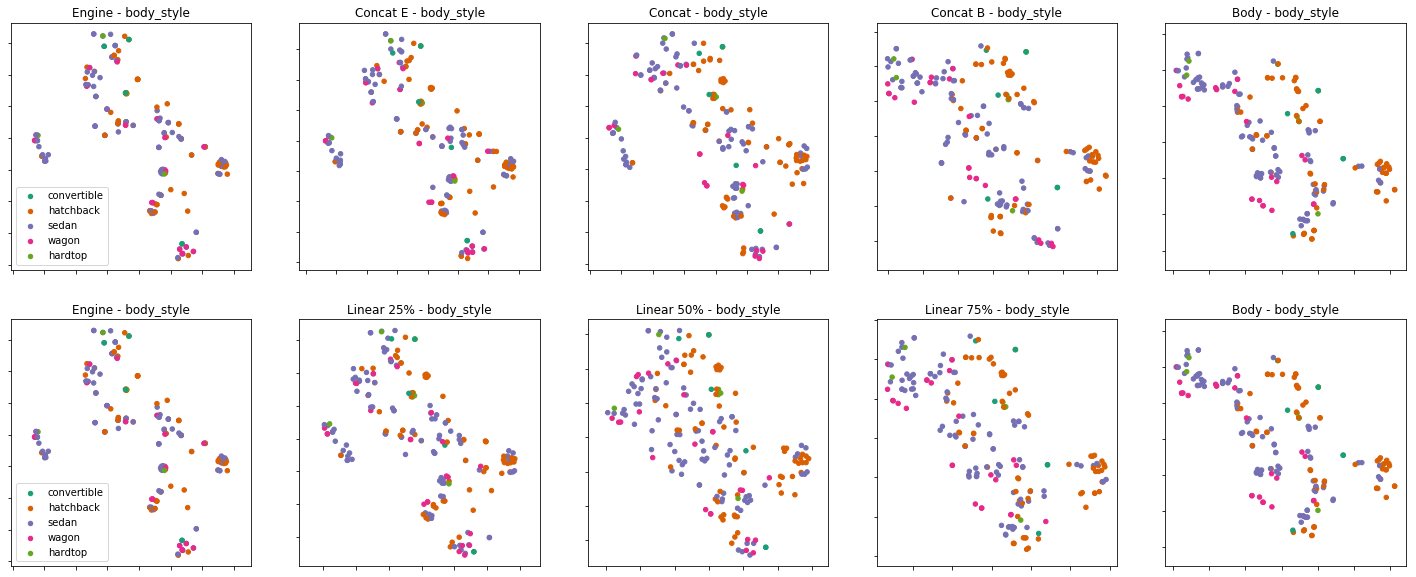

In [319]:
blend_compare("body_style")

In [302]:
from scipy.interpolate import spline
from matplotlib.collections import LineCollection

def plot_motion(maps, meta_attr, legend=True, ax=None):
    if not ax:
        fig, ax = plt.subplots(1, 1, figsize=(20,20))
    Y = np.array([m.y for m in maps])
    D, N, _ = Y.shape
    vals = avail_data[meta_attr].unique()
    mapping = dict(zip(vals, range(len(vals))))
    colors = [COLORS[mapping[s] % len(COLORS)] for s in avail_data[meta_attr]]
    torig = np.arange(D)
    tnew = np.linspace(0, D-1, 100)
    lwidths = np.linspace(1, 8, 100)
    for i in range(N):
        xvals = spline(torig, Y[:,i,0], tnew)
        yvals = spline(torig, Y[:,i,1], tnew)
        points = np.array([xvals, yvals]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        lines = LineCollection(segments, linewidths=lwidths, color=colors[i], alpha=0.2)
        ax.add_collection(lines)
    ax.scatter(Y[0,:,0], Y[0,:,1], s=100, color=colors, facecolors='none')
    ax.scatter(Y[-1,:,0], Y[-1,:,1], s=100, color=colors)
    
    if legend:
        for style, idx in mapping.items():
            ax.scatter([], [], color=COLORS[idx], label=style, s=100)
        ax.scatter([], [], color='grey', label=maps[0].name, s=100, facecolors='none')
        ax.scatter([], [], color='grey', label=maps[-1].name, s=100)
        ax.legend()
    
    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_major_formatter(plt.NullFormatter())
    ax.axis('equal')
    ax.set_title("{} through {} colored by {}".format(maps[0].name, maps[-1].name, meta_attr))

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
  app.launch_new_instance()
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.


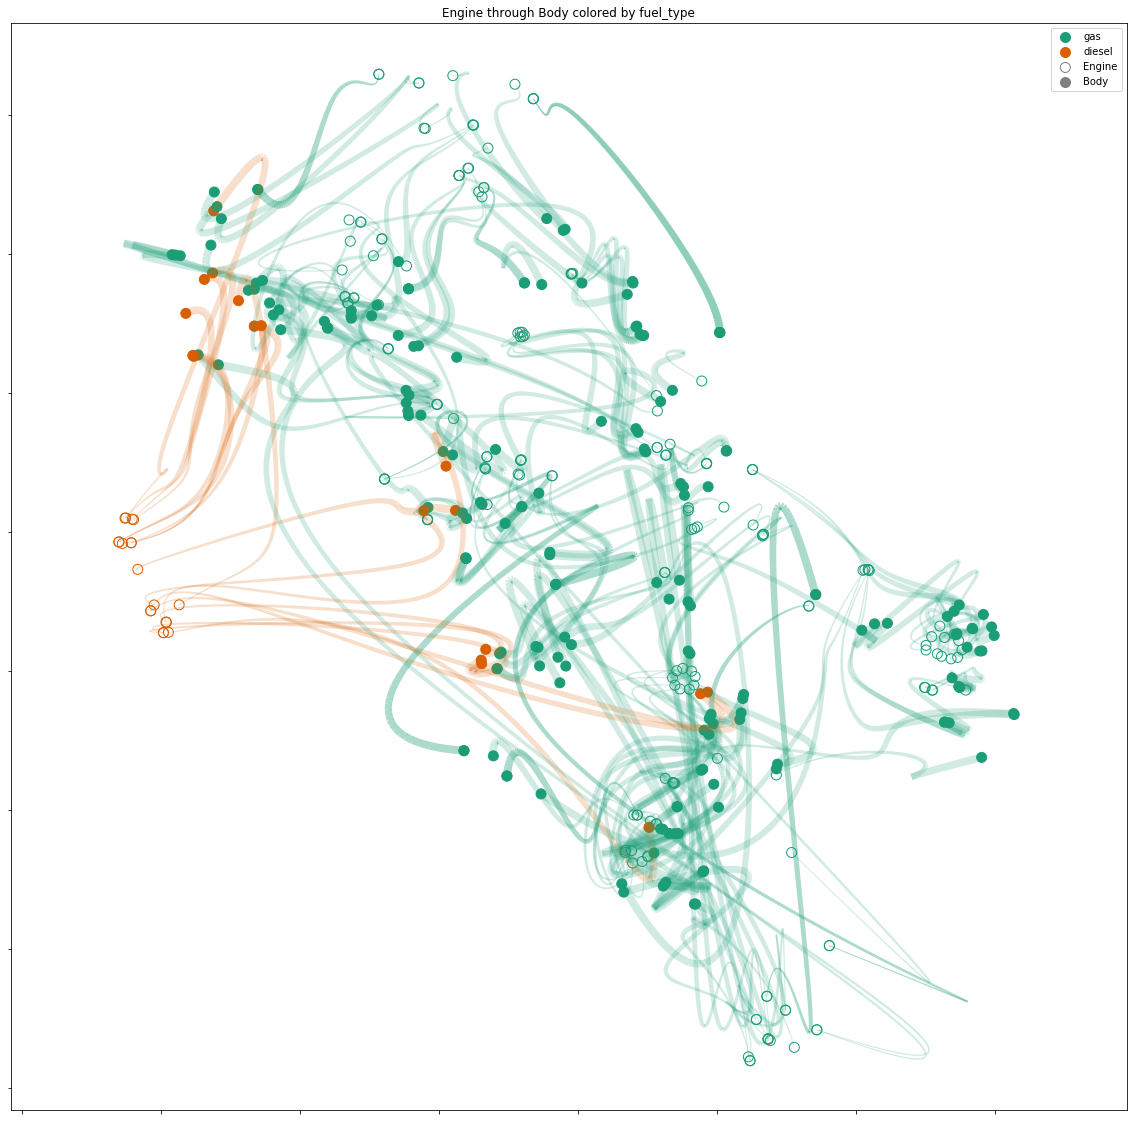

In [303]:
plot_motion([engine_map, linear_25, linear_50, linear_75, body_map], "fuel_type")

In [312]:
linear_maps = []
prior = engine_map
for p in np.linspace(0.0, 1.0, 11):
    m = MAP.create_map("Linear {:.0%} Engine".format(1-p), engine_map.prob * (1-p) + body_map.prob * p, prior=prior)
    prior = m
    linear_maps.append(m)

In [313]:
concat_maps = []
prior = engine_map
for p in np.linspace(0.0, 1.0, 11):
    data = concat_data.copy()
    data[:,0:6] *= (1/6.) * (1-p)
    data[:,6:11] *= (1/5.) * p
    m = MAP.create_map_from_data("Weighted {:.0%} Engine".format(1-p), data, prior=prior)
    prior = m
    concat_maps.append(m)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
  app.launch_new_instance()
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.


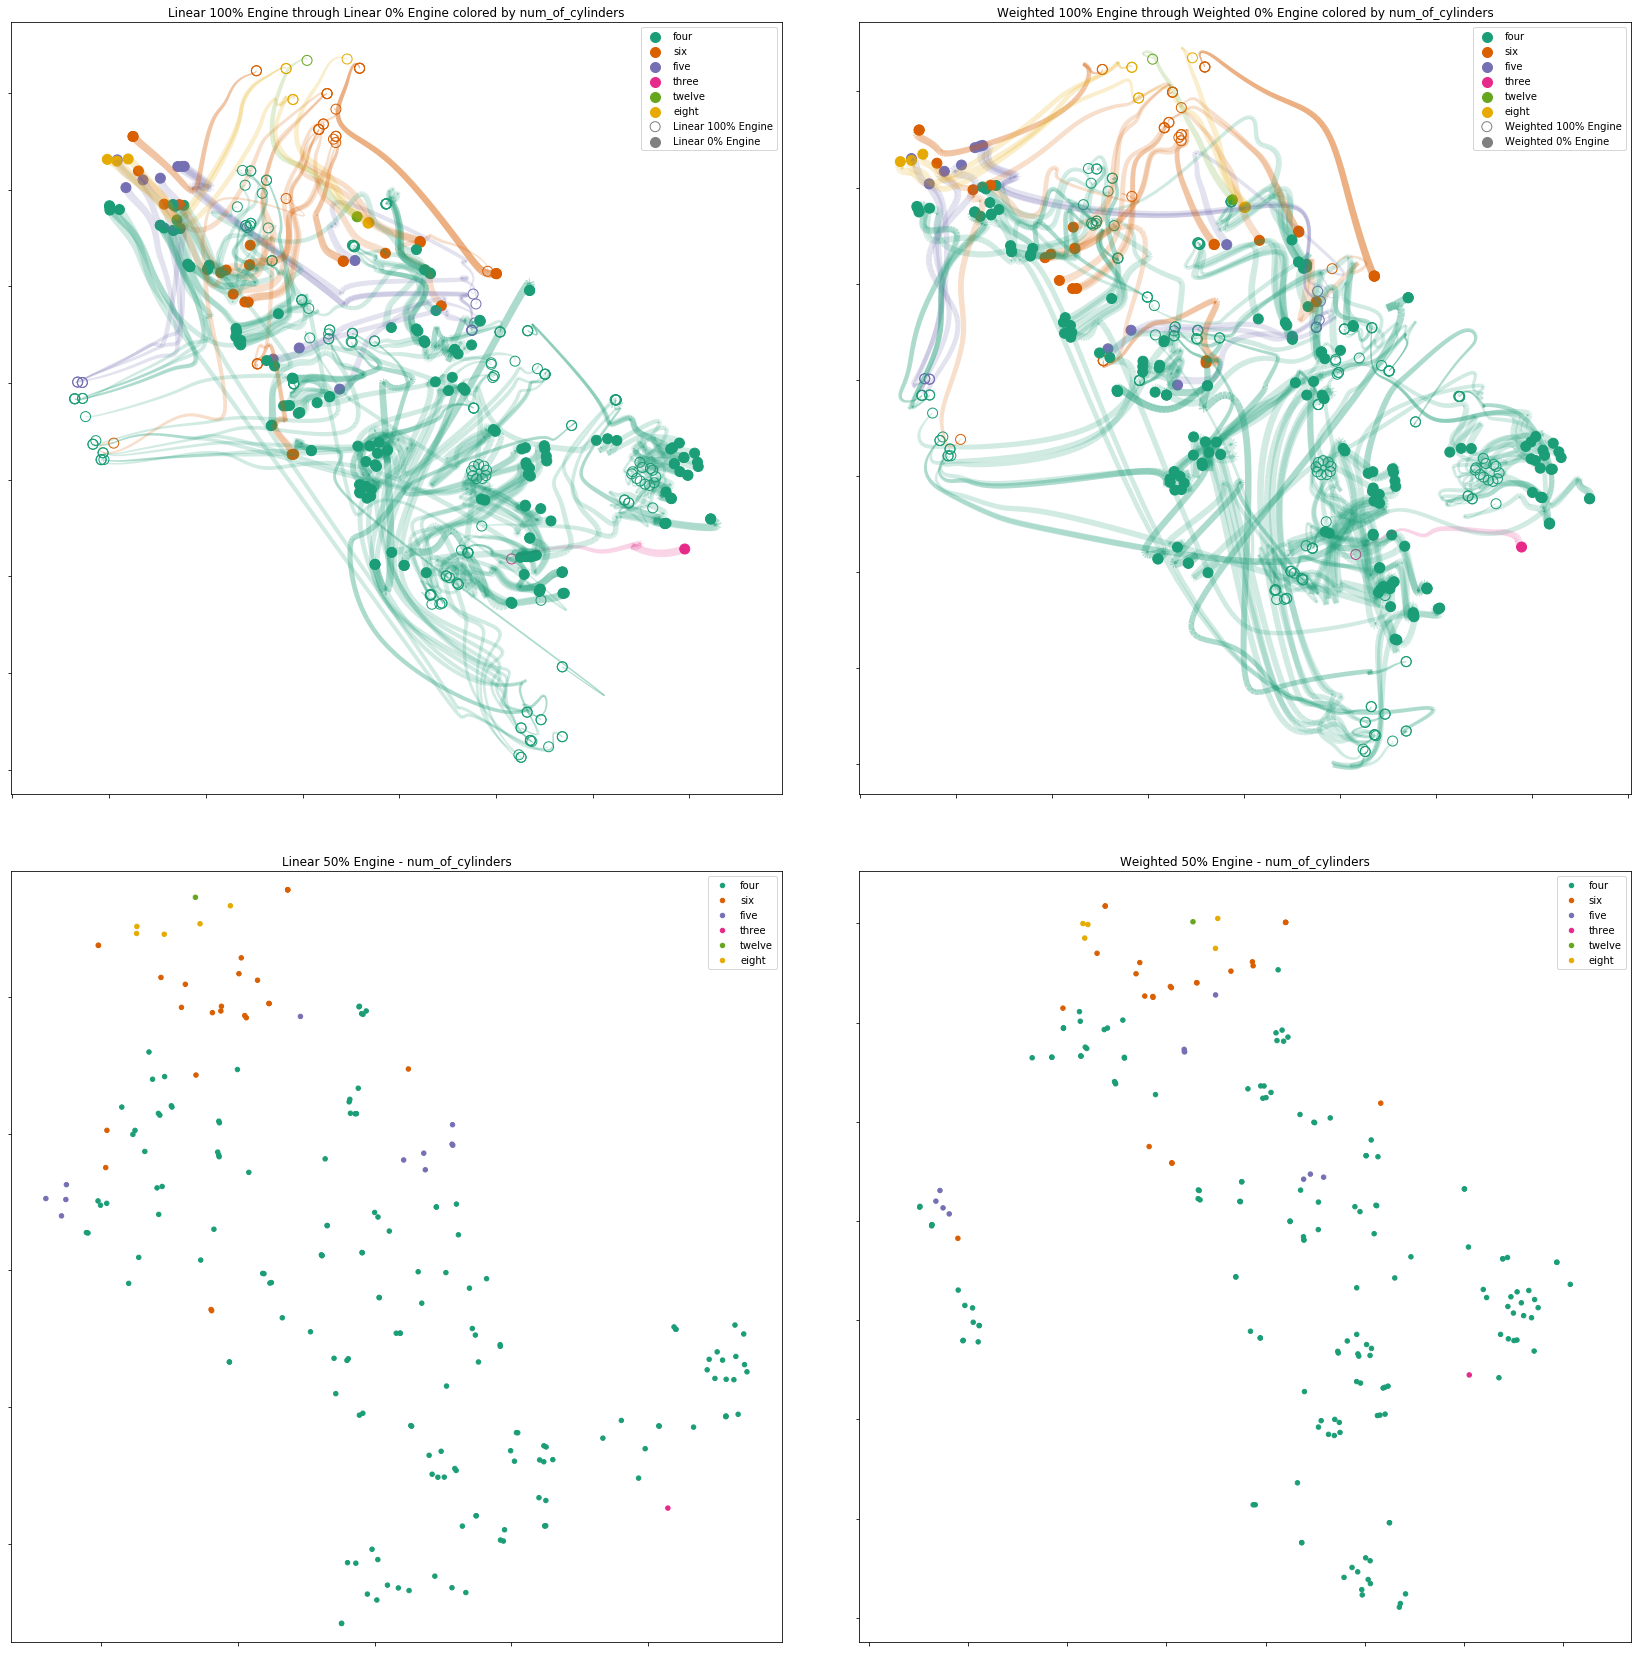

In [317]:
fig, ax = plt.subplots(2, 2, figsize=(25, 25))
plot_motion(linear_maps, "num_of_cylinders", ax=ax[0,0])
plot_motion(concat_maps, "num_of_cylinders", ax=ax[0,1])
color_by(ax[1,0], linear_maps[5], "num_of_cylinders")
color_by(ax[1,1], concat_maps[5], "num_of_cylinders")
fig.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.95, hspace=0.1, wspace=0.1)

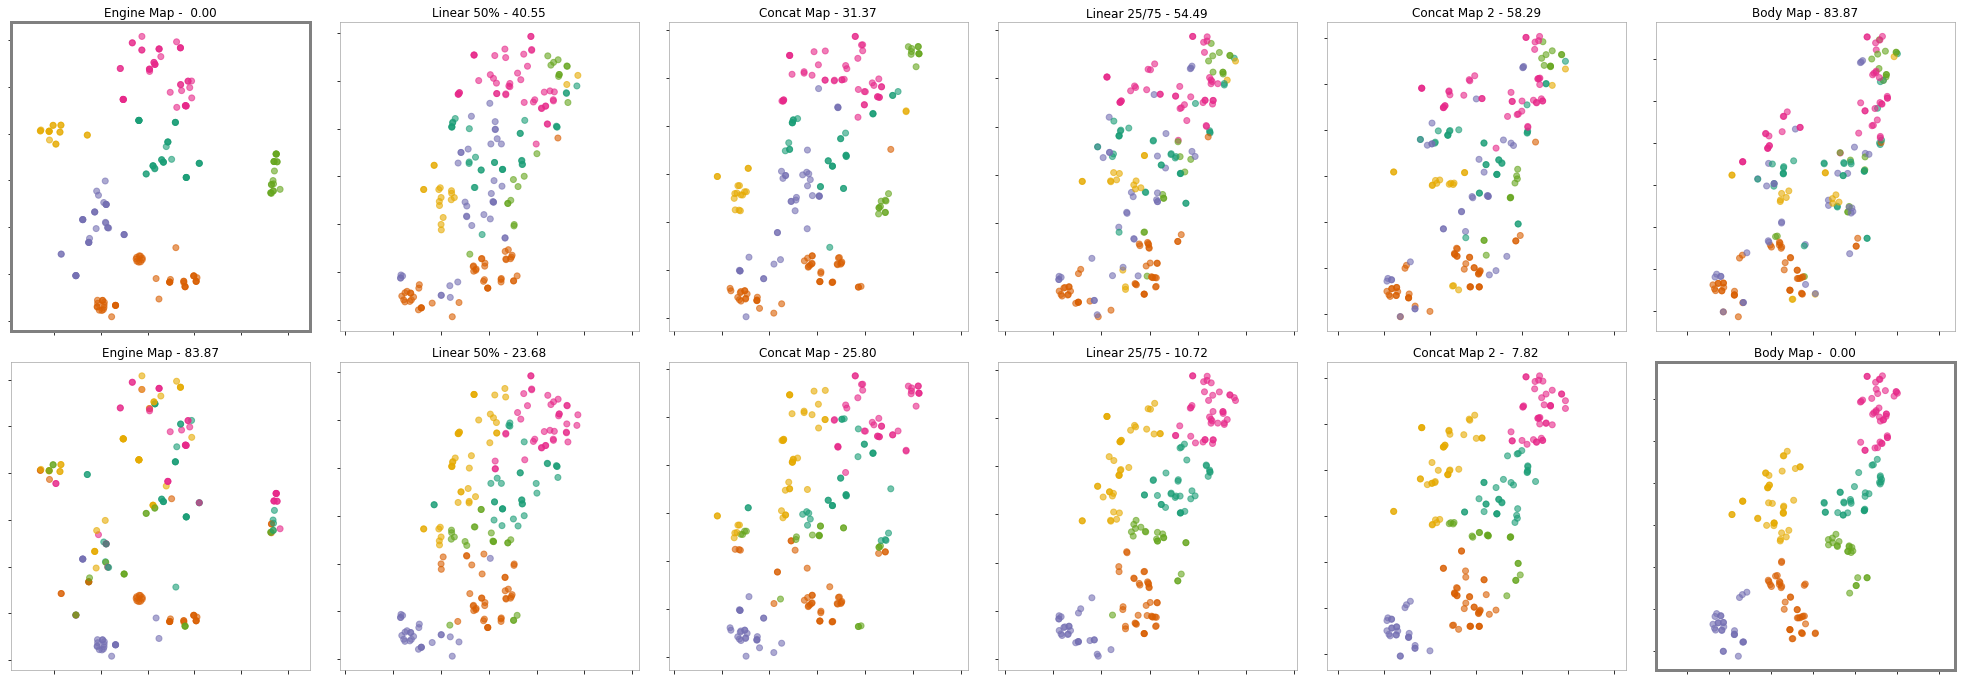

In [87]:
MAP.show_map_matrix([engine_map, linear_map, concat_map, linear_map2, concat_map2, body_map], keys=[engine_map, body_map])

In [53]:
concat_map1 = MAP.create_map_from_data("Concat1", concat_data, perplexity=20.0, prior=engine_map)
concat_map2 = MAP.create_map_from_data("Concat2", concat_data, perplexity=20.0, prior=body_map)

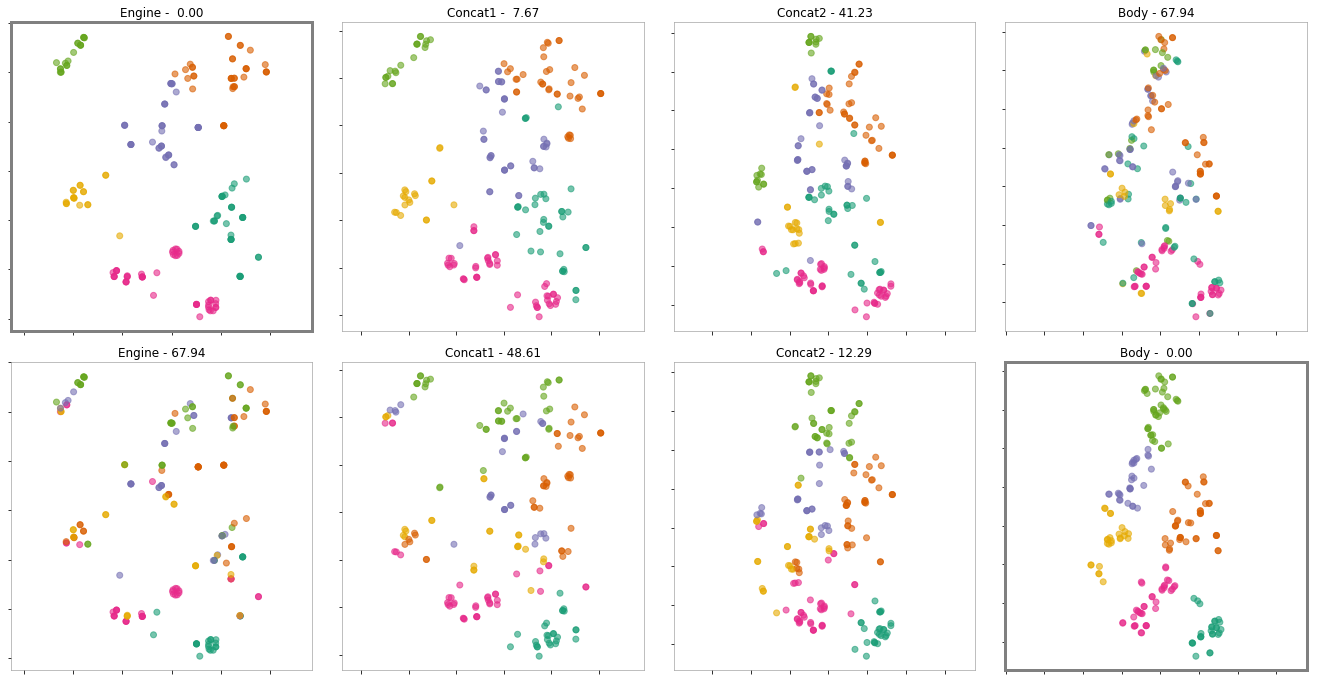

In [54]:
MAP.show_map_matrix([engine_map, concat_map1, concat_map2, body_map], keys=[engine_map, body_map])

In [55]:
linear_p = (engine_map.prob + body_map.prob) * 0.5
linear_map1 = MAP.create_map("Linear 1", linear_p, prior=engine_map)
linear_map2 = MAP.create_map("Linear 2", linear_p, prior=body_map)

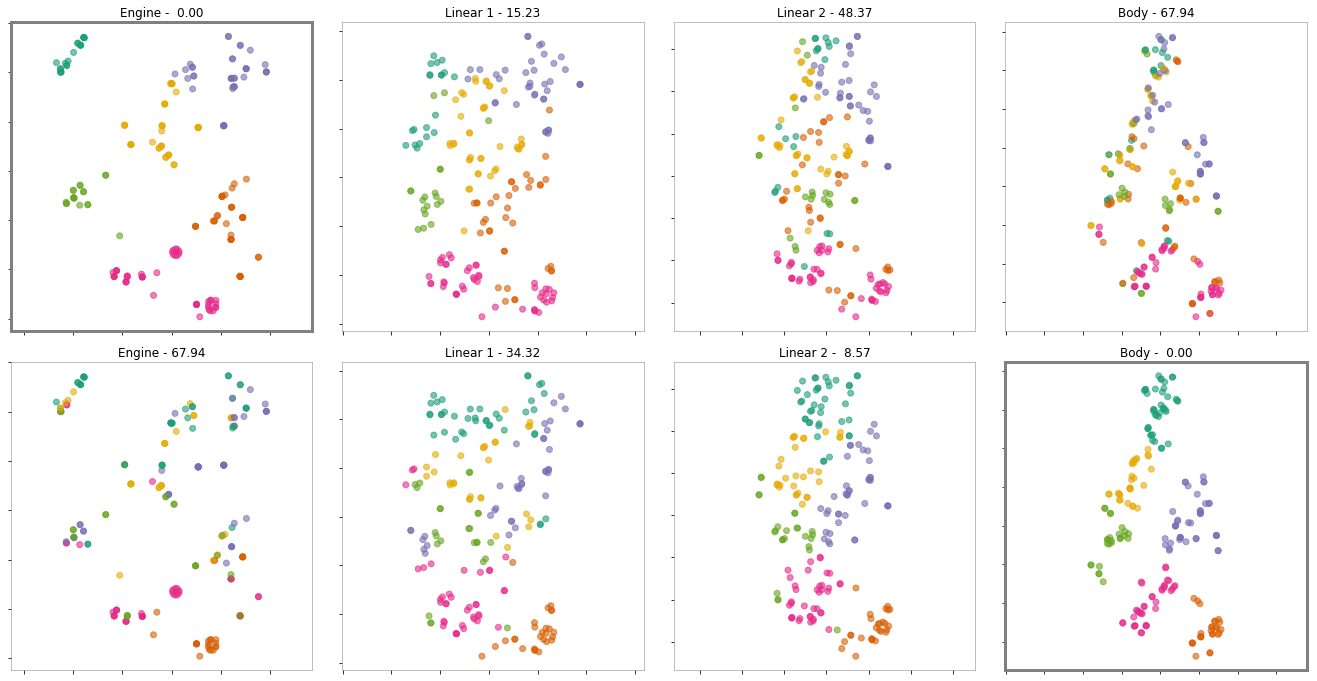

In [56]:
MAP.show_map_matrix([engine_map, linear_map1, linear_map2, body_map], keys=[engine_map, body_map])

In [15]:
min_p = MAP.renorm_probs(np.minimum(engine_map.prob, body_map.prob))
min_map = MAP.create_map("Min", min_p, prior=engine_map)

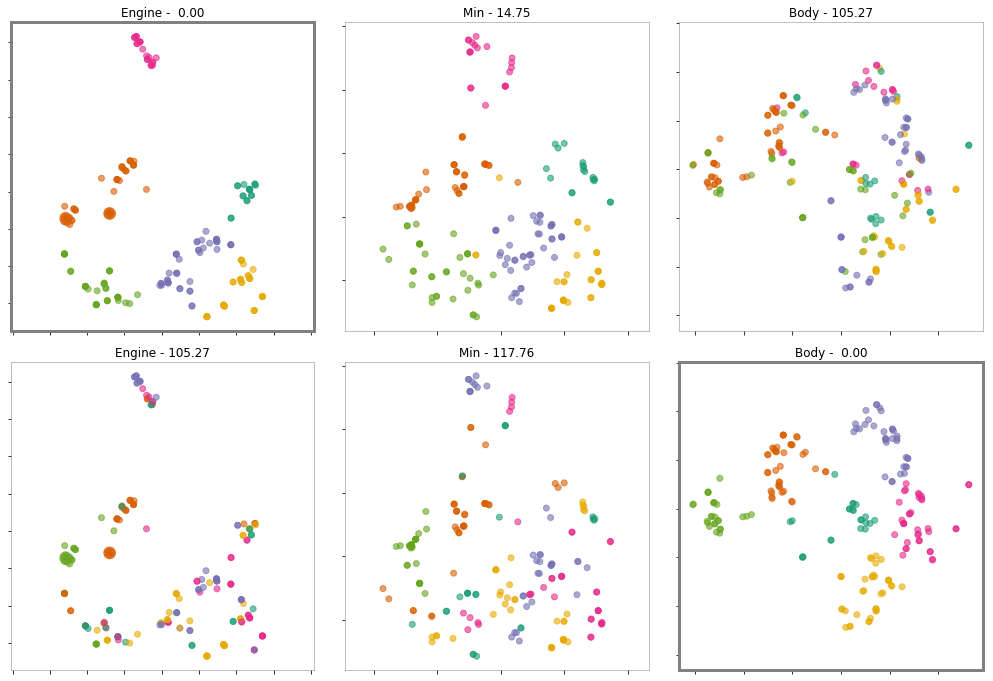

In [17]:
MAP.show_map_matrix([engine_map, min_map, body_map], keymaps=[engine_map, body_map])

In [18]:
product_p = MAP.renorm_probs(engine_map.prob * body_map.prob)
product_map = MAP.create_map("Product", product_p, prior=engine_map)

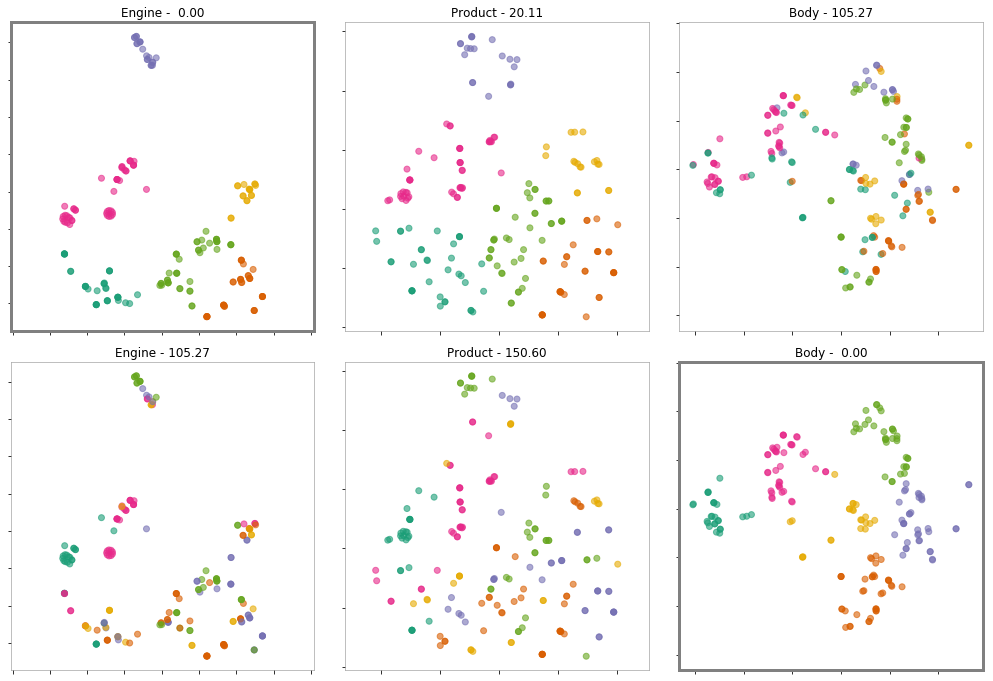

In [19]:
MAP.show_map_matrix([engine_map, product_map, body_map], keymaps=[engine_map, body_map])

In [15]:
minusone_p = MAP.renorm_probs(2 * (engine_map.prob**-1 + body_map.prob**-1)**-1)
minusone_map = MAP.create_map("MinusOne", minusone_p, prior=engine_map)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in reciprocal
  """Entry point for launching an IPython kernel.


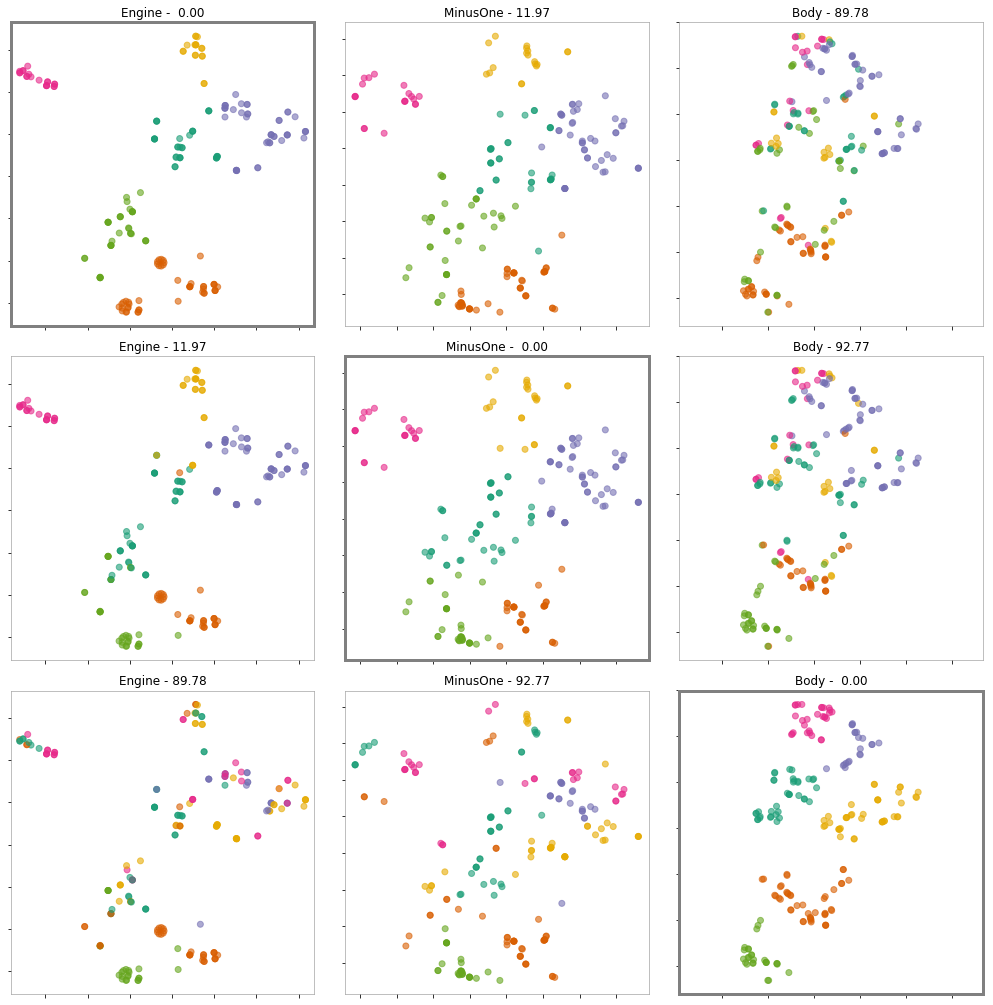

In [16]:
MAP.show_map_matrix([engine_map, minusone_map, body_map], k=6)

In [18]:
sumdist_p = MAP.renorm_probs(np.exp(np.log(engine_map.prob) + np.log(body_map.prob)))
sumdist_map = MAP.create_map("SumDist", sumdist_p, prior=engine_map)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


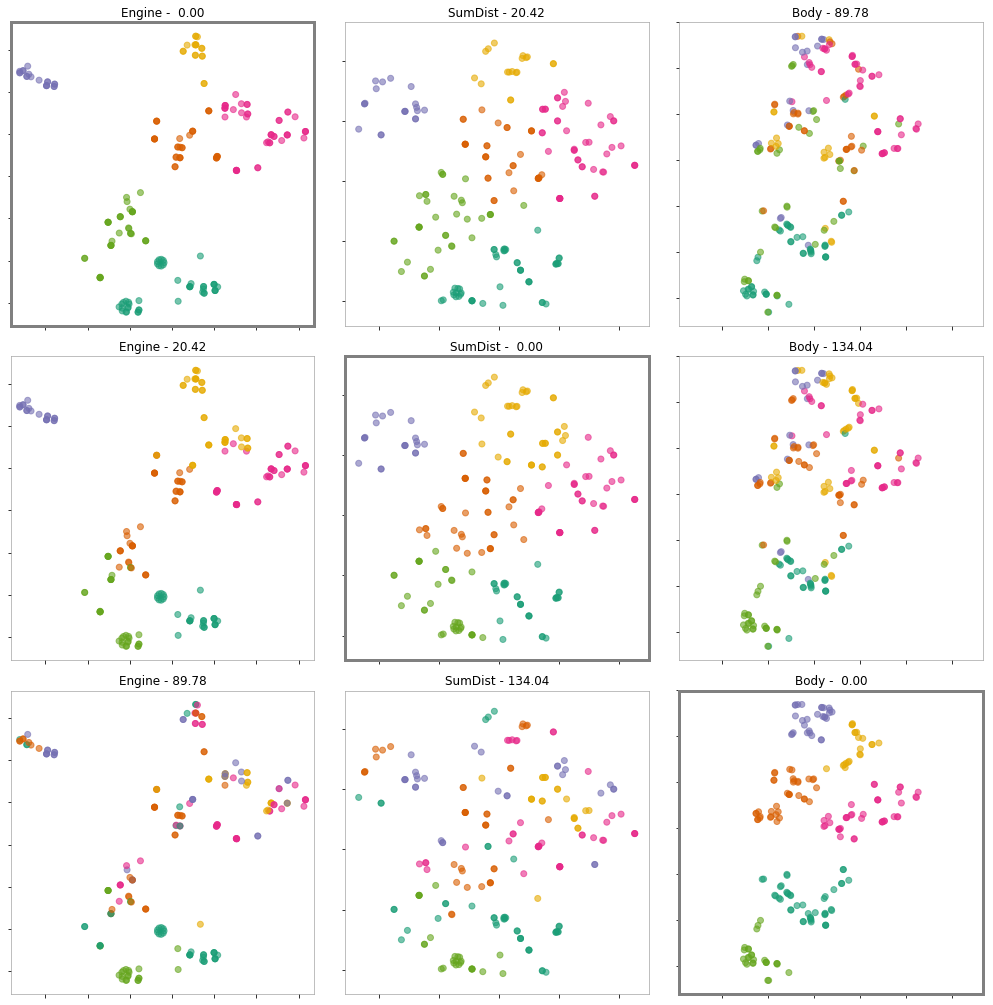

In [19]:
MAP.show_map_matrix([engine_map, sumdist_map, body_map], k=6)

In [20]:
max_p = MAP.renorm_probs(np.maximum(engine_map.prob, body_map.prob))
max_map = MAP.create_map("Max", max_p, prior=engine_map)

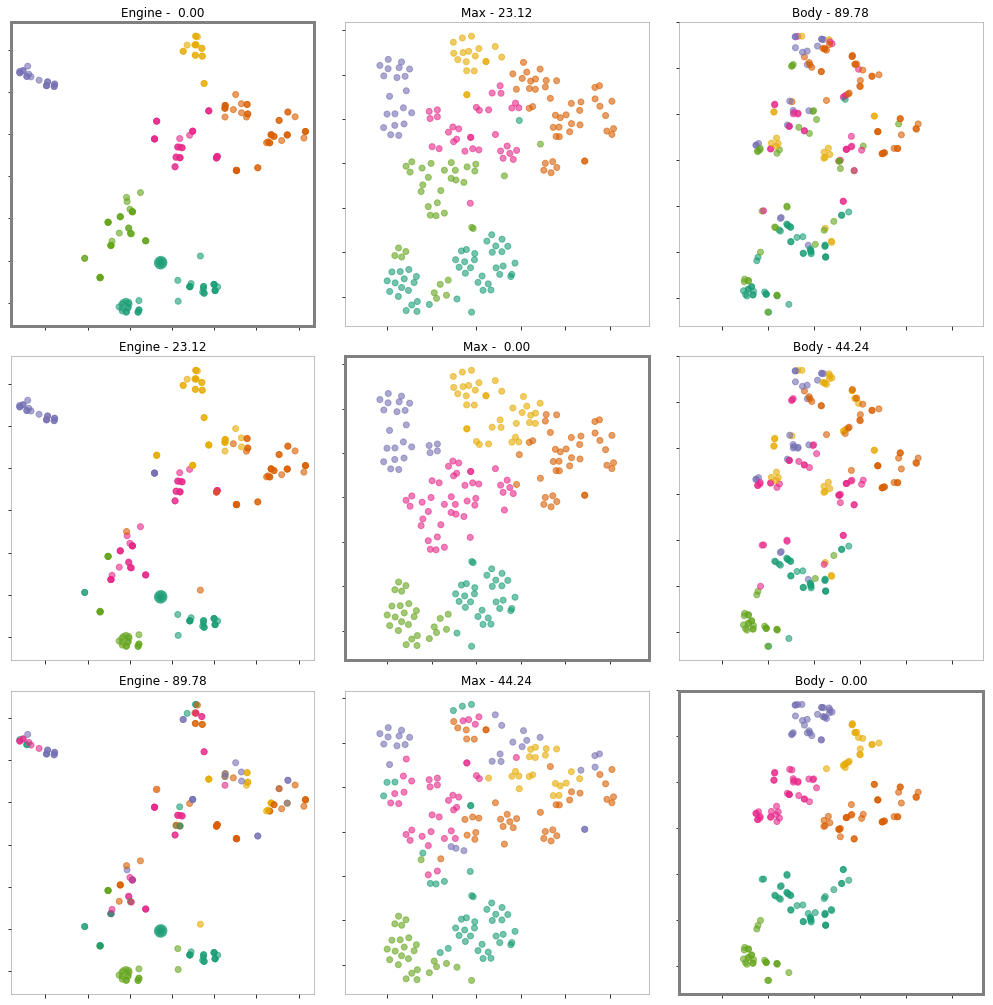

In [21]:
MAP.show_map_matrix([engine_map, max_map, body_map], k=6)

In [22]:
l2_p = MAP.renorm_probs(np.sqrt(engine_map.prob**2 + body_map.prob**2) / np.sqrt(2))
l2_map = MAP.create_map("L2", l2_p, prior=engine_map)

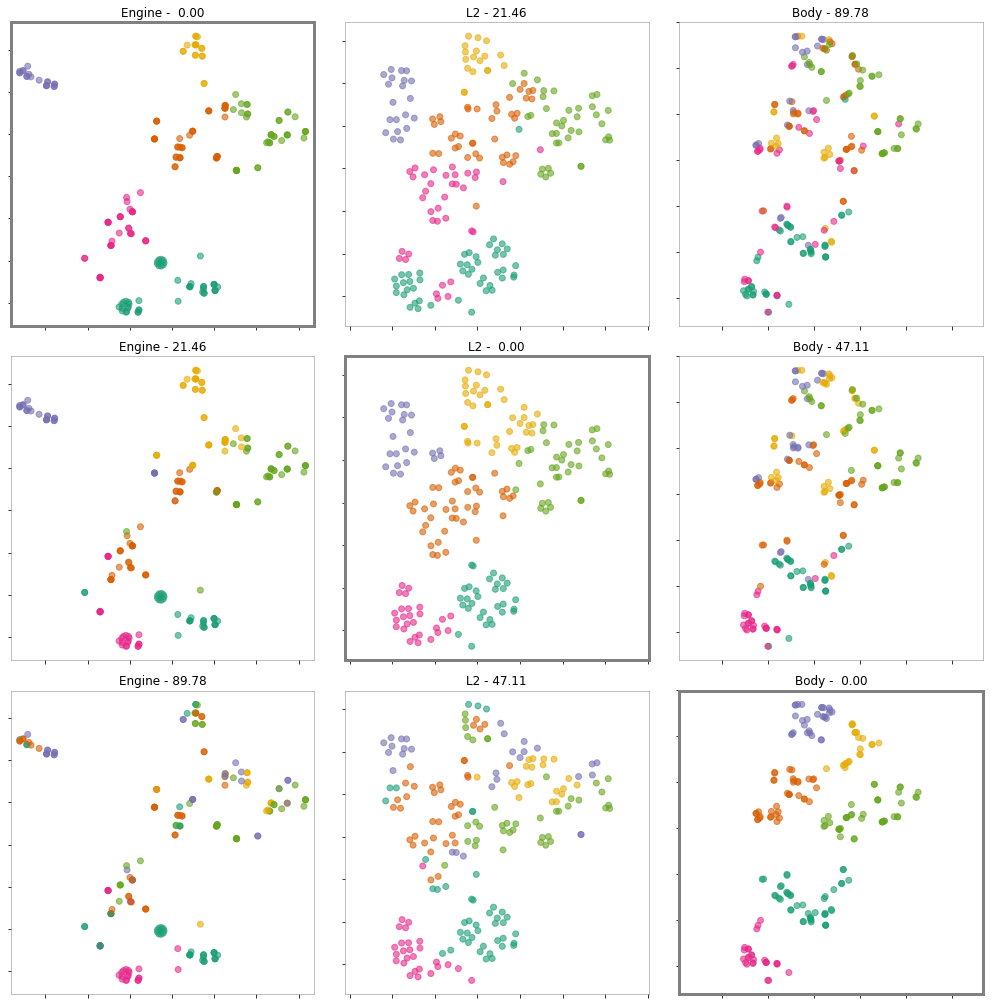

In [23]:
MAP.show_map_matrix([engine_map, l2_map, body_map], k=6)

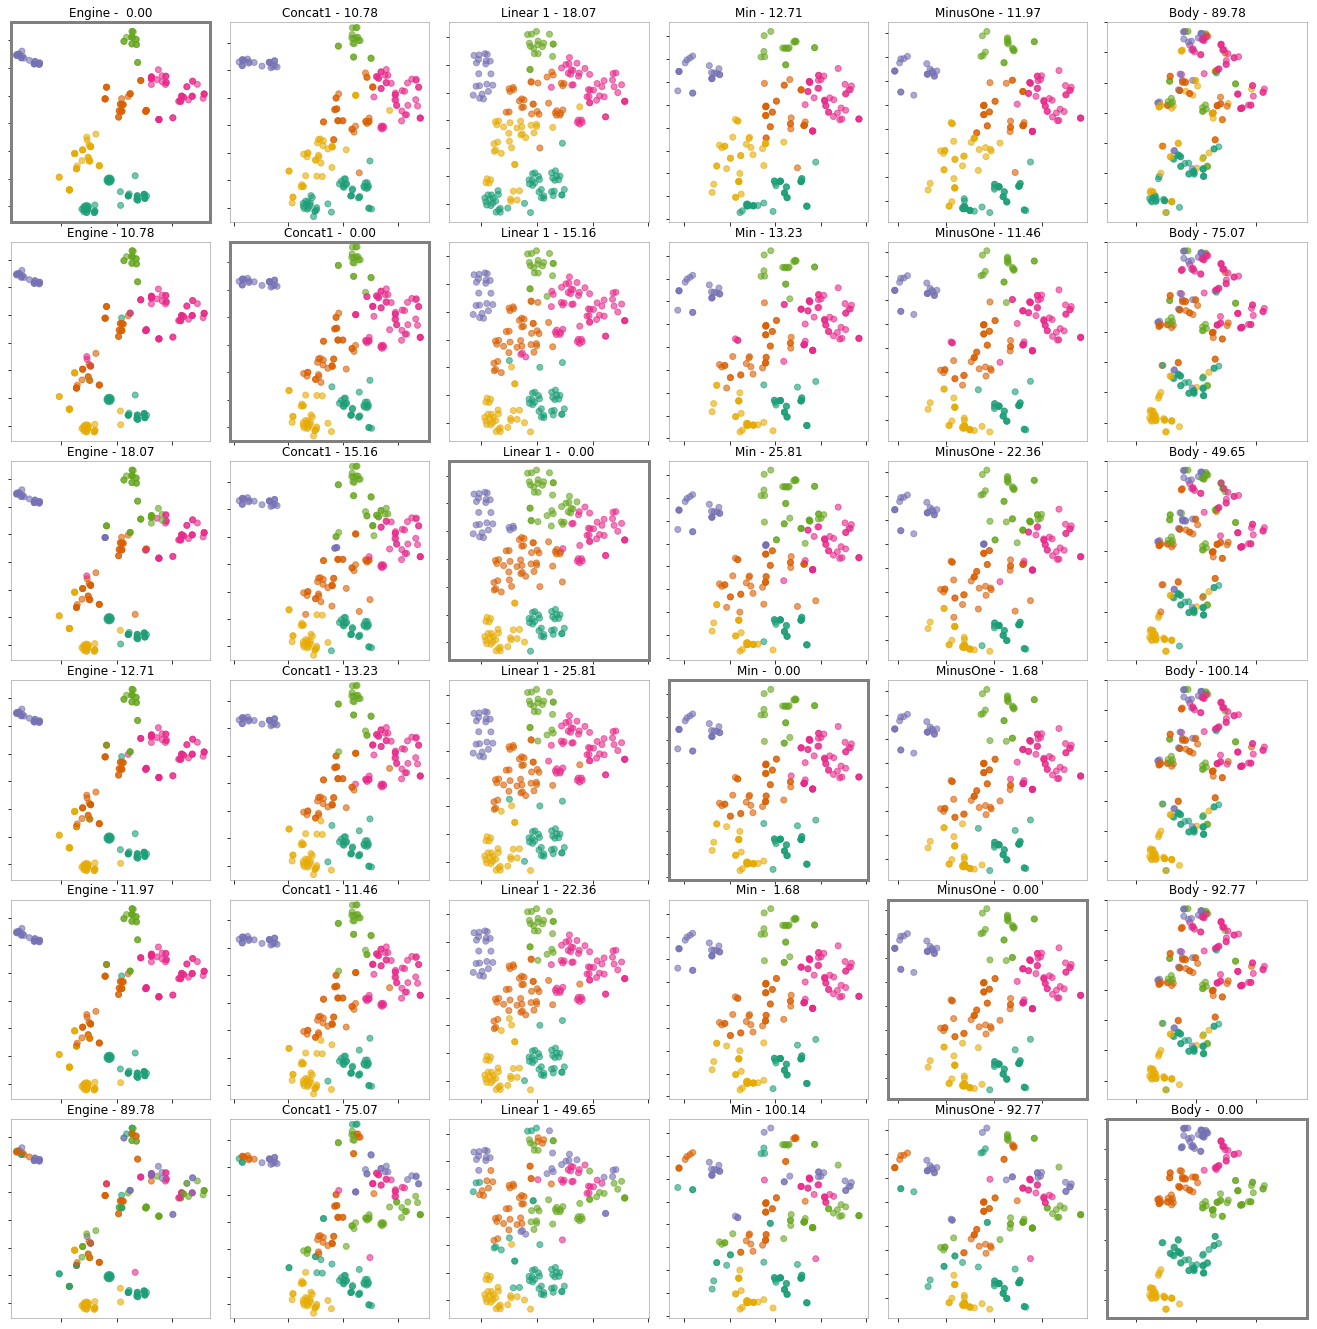

In [24]:
MAP.show_map_matrix([engine_map, concat_map1, linear_map1, min_map, minusone_map, body_map], k=6, size=20)

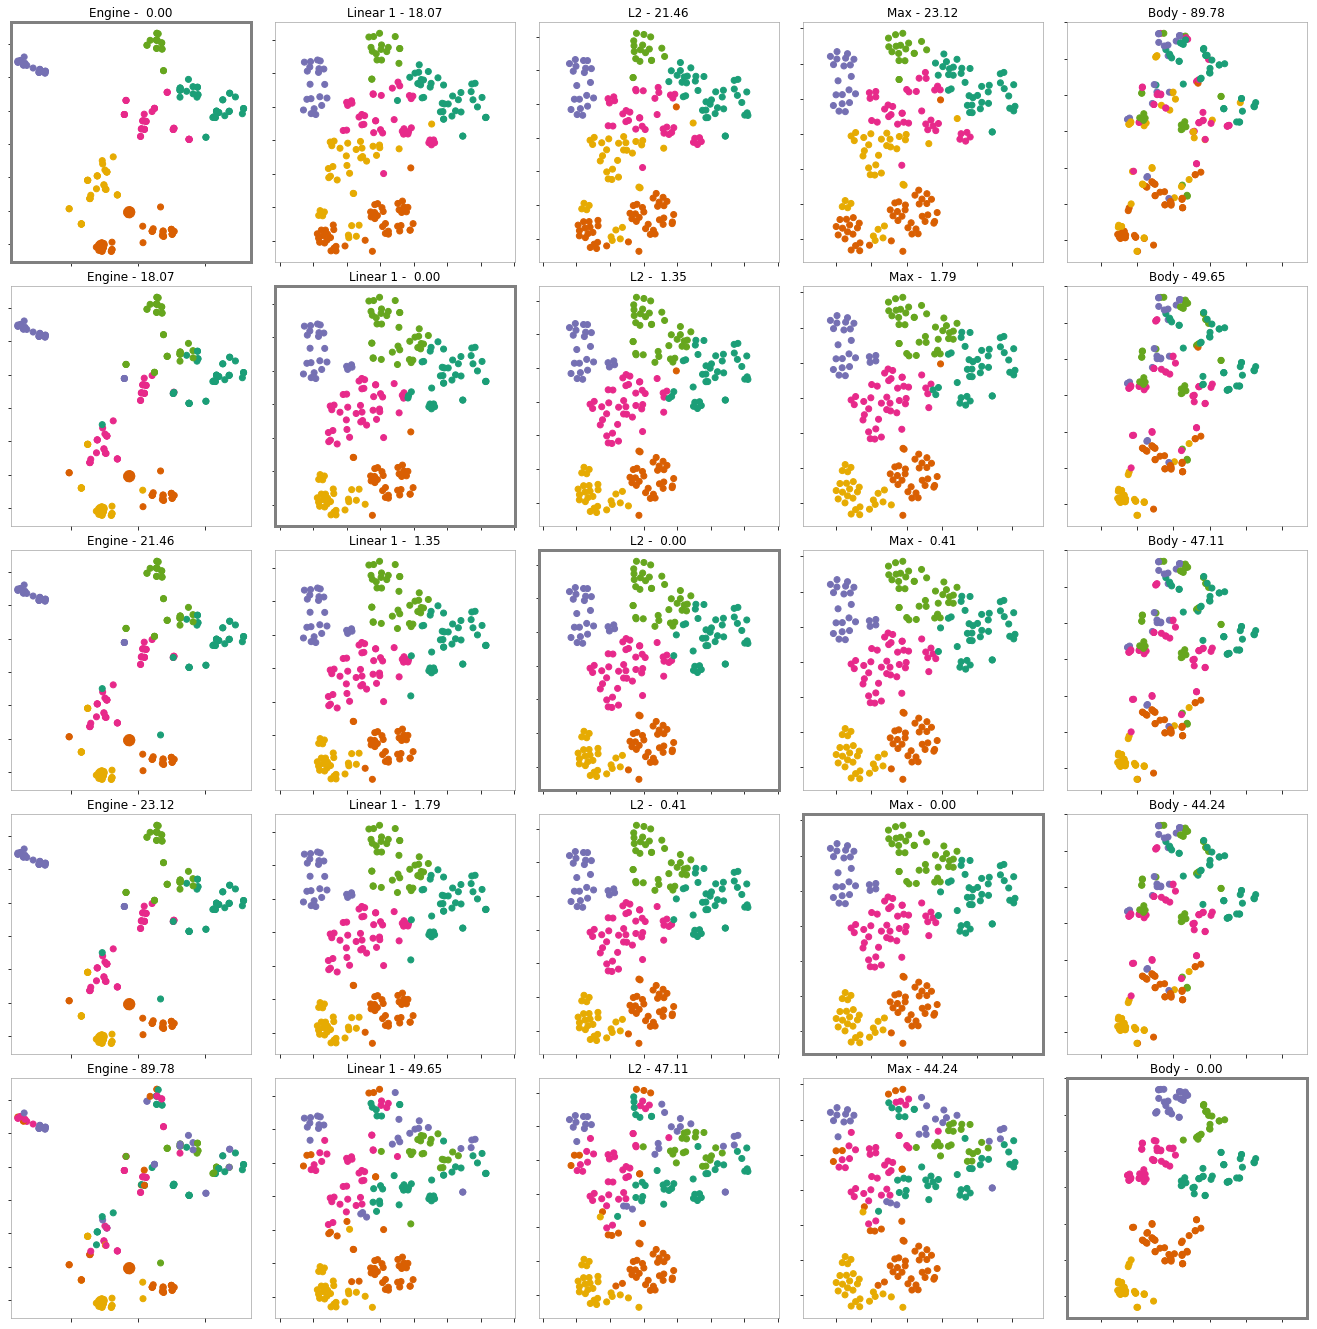

In [25]:
MAP.show_map_matrix([engine_map, linear_map1, l2_map, max_map, body_map], k=6, size=20, alpha=1.0)

In [26]:
engine_map1 = MAP.create_map("Engine1", engine_map.prob, num_iters=5000)
engine_map2 = MAP.create_map("Engine2", engine_map.prob, num_iters=5000)

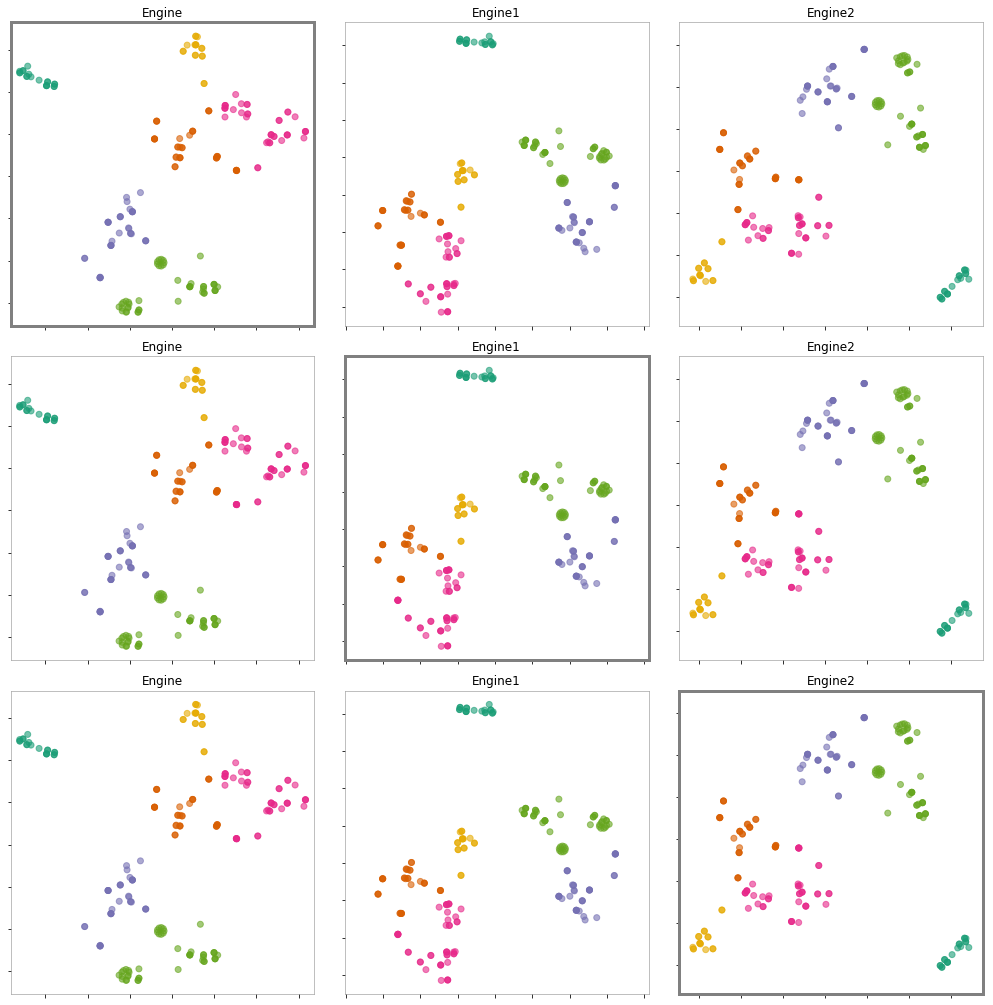

In [27]:
MAP.show_map_matrix([engine_map, engine_map1, engine_map2], score=False)

In [28]:
body_map1 = MAP.create_map("Body1", body_map.prob, num_iters=5000)
body_map2 = MAP.create_map("Body2", body_map.prob, num_iters=5000)

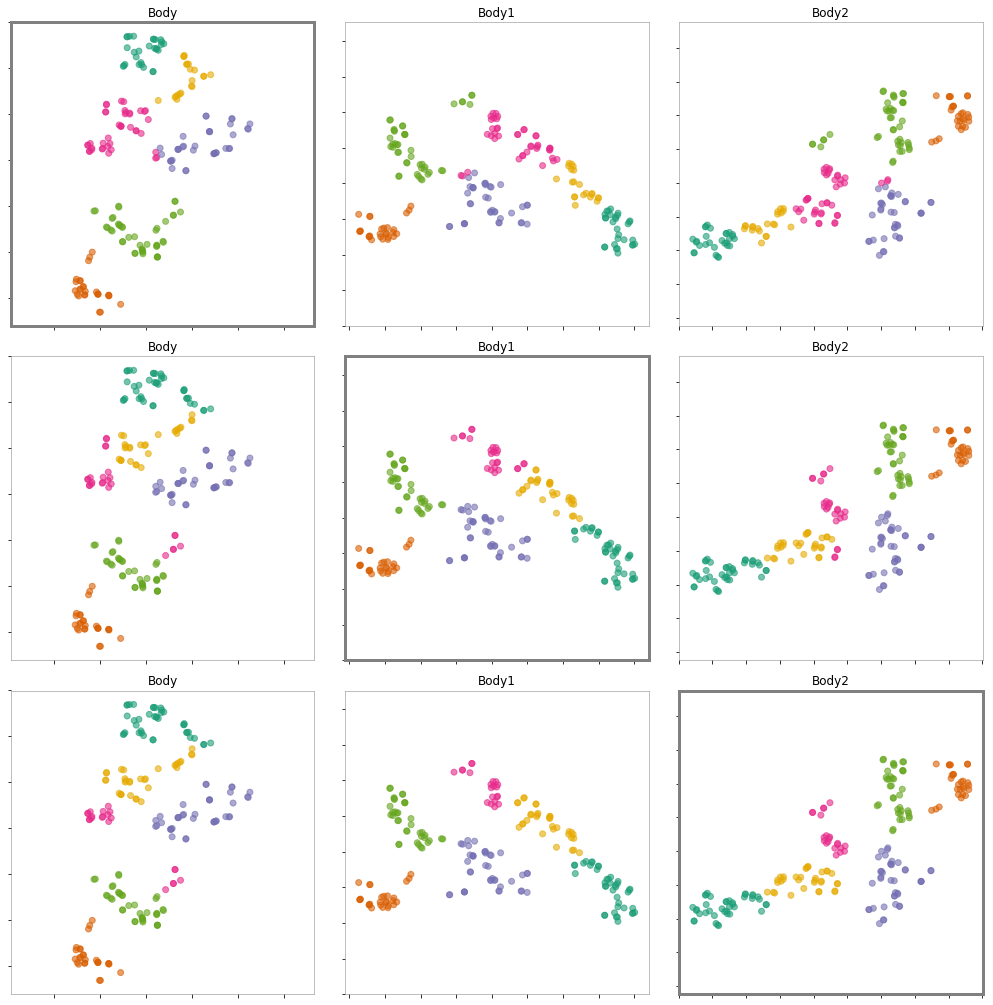

In [29]:
MAP.show_map_matrix([body_map, body_map1, body_map2], score=False)

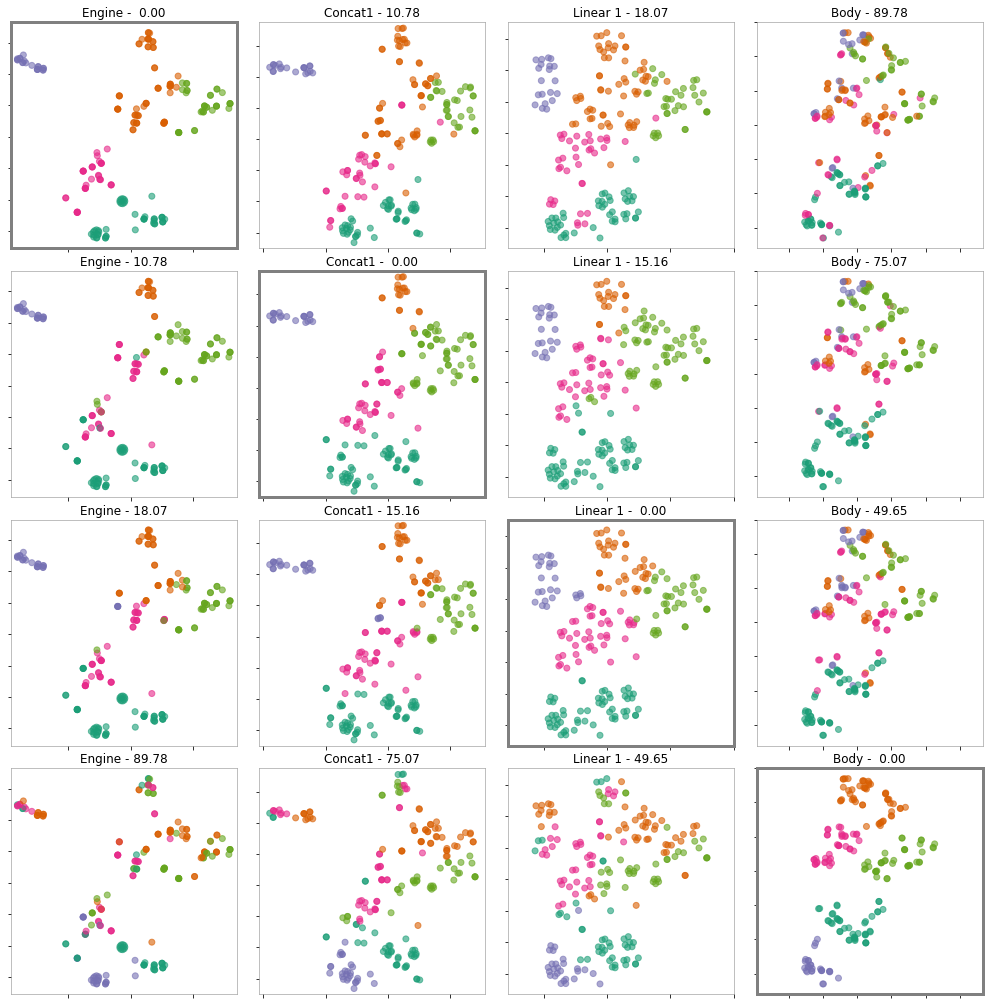

In [30]:
MAP.show_map_matrix([engine_map, concat_map1, linear_map1, body_map], k=5)

In [31]:
linear75e_p = 0.75*engine_map.prob + 0.25*body_map.prob
linear25e_p = 0.25*engine_map.prob + 0.75*body_map.prob

linear75e_map = MAP.create_map("75% Engine", linear75e_p, prior=engine_map)
linear50e_map = MAP.create_map("50% Engine", linear_p, prior=linear75e_map)
linear25e_map = MAP.create_map("25% Engine", linear25e_p, prior=linear50e_map)
linear0e_map = MAP.create_map("0% Engine", body_map.prob, prior=linear25e_map)

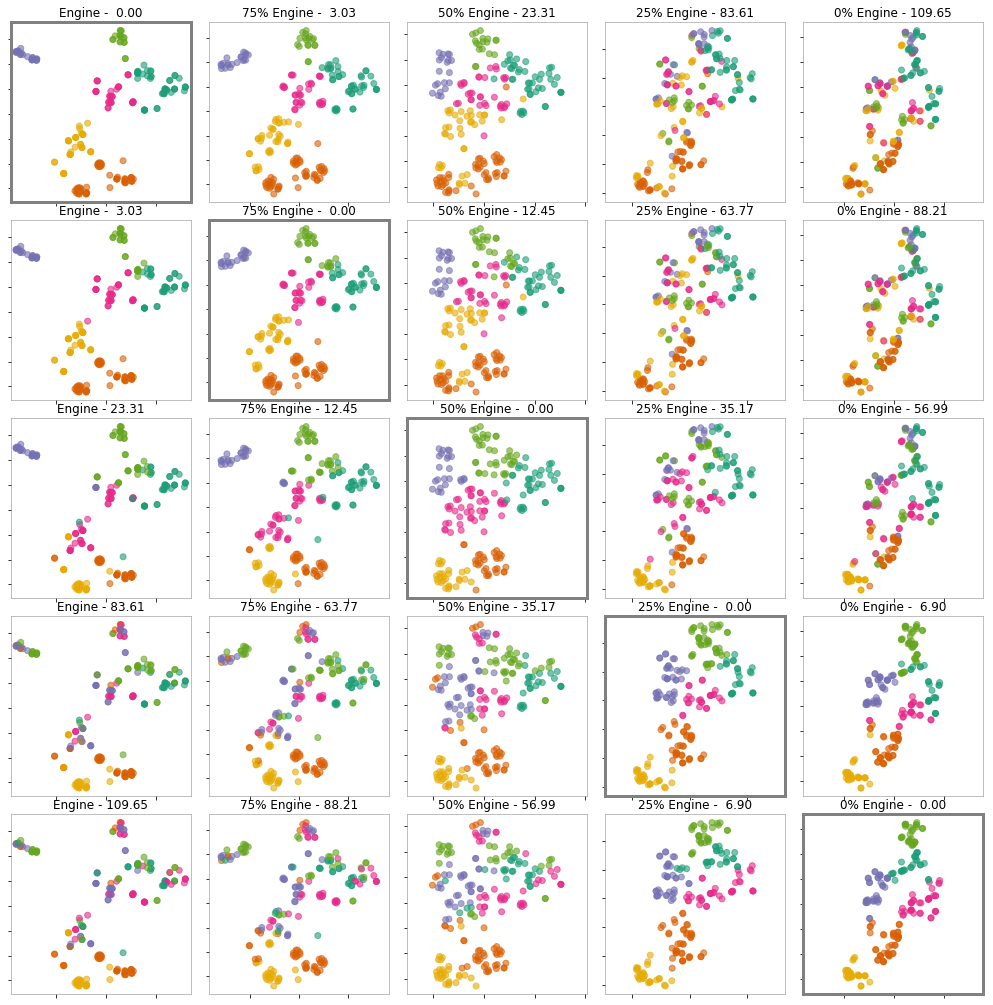

In [32]:
MAP.show_map_matrix([engine_map, linear75e_map, linear50e_map, linear25e_map, linear0e_map])

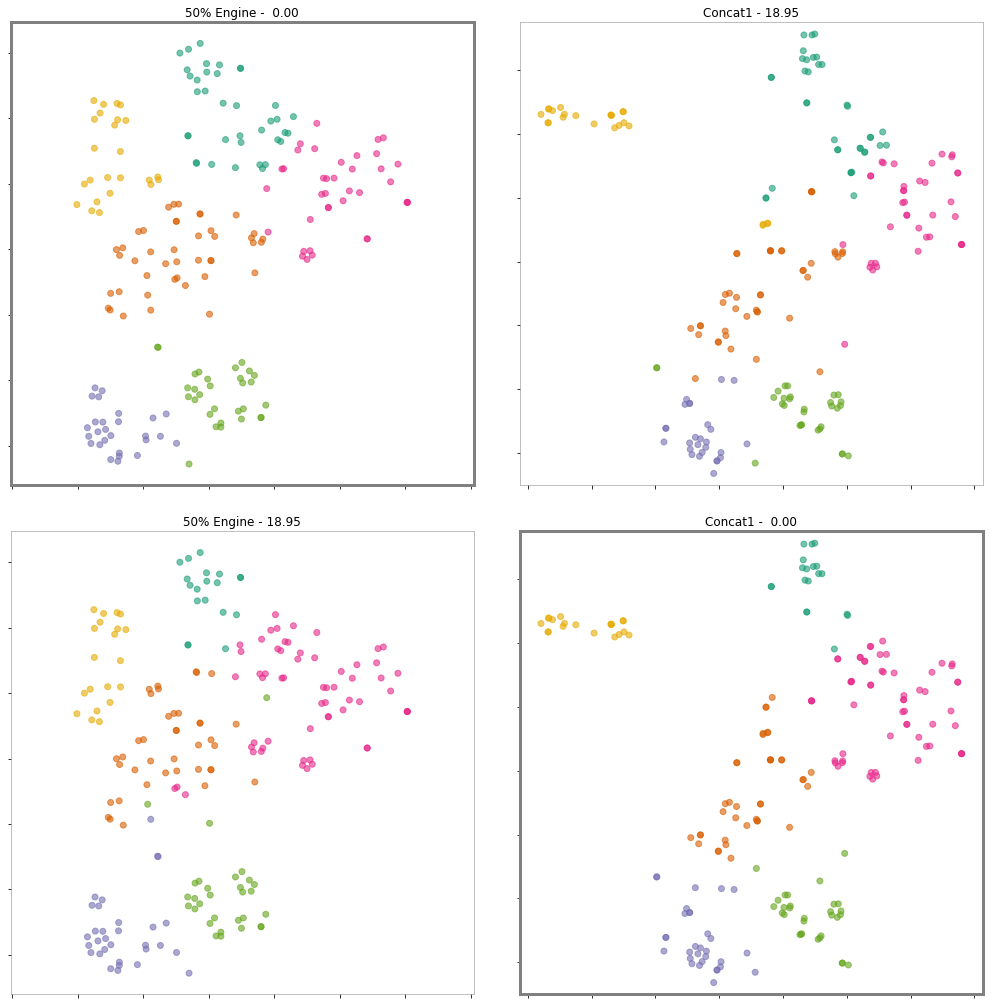

In [33]:
MAP.show_map_matrix([linear50e_map, concat_map1])

In [175]:
import scipy.interpolate
scipy.interpolate.BSpline?